In [22]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import functools
import operator

In [23]:
weather_data = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../data/Plant_1_Generation_Data.csv')

In [24]:
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])

In [25]:
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,136,15,00:15:00,0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,136,30,00:30:00,0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,136,45,00:45:00,0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,136,60,01:00:00,1


In [5]:
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))


In [26]:
def Irr_dc_linear_fit(data):
    coeff=[]
    days=[]
    inverters=[]
    for i in data.SOURCE_KEY.unique():
        inv_data=data[data.SOURCE_KEY==i]
        for a, day in inv_data.groupby(inv_data.DAY):
            inverters.append(i)
            INV=pd.DataFrame(data=np.array(inverters), columns=['SOURCE_KEY'])
            days.append(a)
            DAYS=pd.DataFrame(data=np.array(days), columns=['DAY'])
            X = day['IRRADIATION'].values.reshape(-1,1)
            y = day['DC_POWER'].values.reshape(-1,1)
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            m=regressor.coef_
            result = []
            [result.extend(el) for el in m] 
            E=[]
            for el in result:
                E.append(el)
            coeff.append(E)
            coefficients = pd.DataFrame(data=np.array(coeff), columns=['Conversion_coeff'])
            conv = [INV, DAYS, coefficients]
            conversion_data = pd.concat(conv, axis=1)
    return conversion_data
new_d = Irr_dc_linear_fit(merged_df)


In [27]:
def outliar_detection(data, anomaly_limit = 2):
    x = pd.DataFrame(columns = ['SOURCE_KEY','DAY','Conversion_coeff','Conv_coeff_outliar'])
    for _,d in data.groupby('DAY'):
        col_mean = d['Conversion_coeff'].mean()
        col_std = d['Conversion_coeff'].std()
        d['Conv_coeff_outliar'] = 0
        d.loc[(d['Conversion_coeff'] > col_mean + anomaly_limit * col_std) | 
              (d['Conversion_coeff'] < col_mean - anomaly_limit * col_std),'Conv_coeff_outliar'] = 1
        x = pd.concat([x,d])
    return x
new_d = outliar_detection(new_d)

C:\Users\Hovsep Avagyan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Hovsep Avagyan\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [28]:
new_d
# def lowest_efficiency_marker(output_of_Irr_dc_linear_fit):
    

,SOURCE_KEY,DAY,Conversion_coeff,Conv_coeff_outliar
0,1BY6WEcLGh8j5v7,136,12211.294660,1
34,1IF53ai7Xc0U56Y,136,13476.171247,0
68,3PZuoBAID5Wc2HD,136,13211.233479,0
102,7JYdWkrLSPkdwr4,136,13081.914966,0
136,McdE0feGgRqW7Ca,136,13751.846468,0
...,...,...,...,...
611,wCURE6d3bPkepu2,169,14016.919171,0
645,z9Y9gH1T5YWrNuG,169,13749.816478,0
679,zBIq5rxdHJRwDNY,169,13906.176724,0
713,zVJPv84UY57bAof,169,14059.452857,0


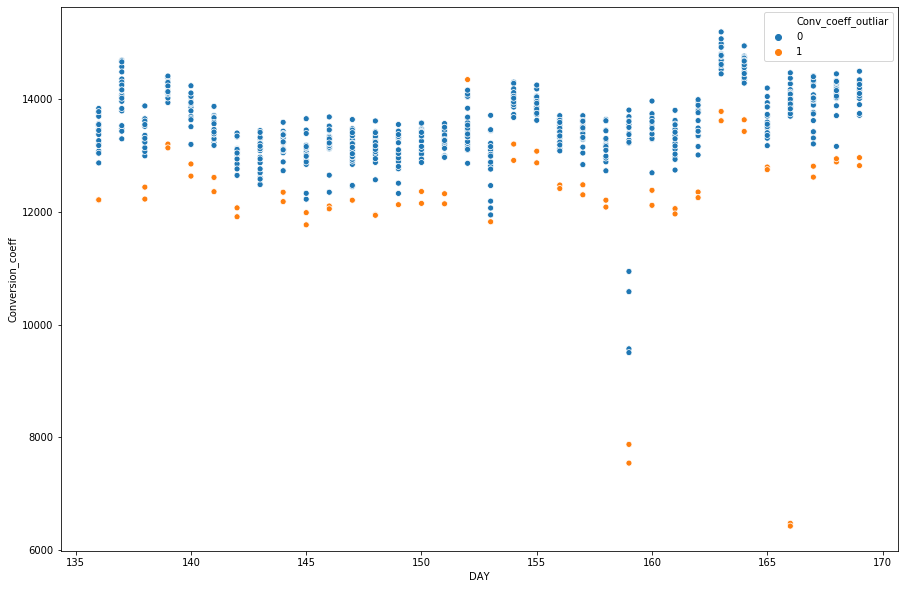

In [29]:
ax=plt.figure(figsize=(15, 10))
sns.scatterplot(x = 'DAY',y = 'Conversion_coeff',data = new_d, hue = 'Conv_coeff_outliar')

In [36]:
new_d['Alarm'] =  new_d.groupby('SOURCE_KEY')['Conv_coeff_outliar'].rolling(window = 7).min()
# df[df == 7]

TypeError: incompatible index of inserted column with frame index